In [45]:
import torch
from torch import nn
from data.dataset import ImageDataset, load_all_from_path #preprocessing code from dataset.py
from models.DLinkNet import LinkNet
from utils import train, accuracy_fn, patch_accuracy_fn
from submit import create_submission_224_patches #our code
from glob import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
model = LinkNet().to(device)

/Users/sebastian/miniforge3/envs/cil/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sebastian/miniforge3/envs/cil/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
checkpoint = torch.load('model_checkpoints/200_DLinkNet_EPFL_Databest.pt', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [7]:
def load_all_from_path(path):
    return np.stack([np.array(Image.open(f)) for f in sorted(glob(path + '/*.png'))]).astype(np.float32) / 255.

In [22]:
def np_to_tensor(x, device):
    # allocates tensors from np.arrays
    if device == 'cpu':
        return torch.from_numpy(x).cpu()
    else:
        return torch.from_numpy(x).contiguous().pin_memory().to(device=device, non_blocking=True)

In [108]:
def get_img_mask_pred(trained_model):
    test_path = 'data/training/images/val'
    test_images = load_all_from_path(test_path)
    test_images = np.stack([cv2.resize(img, dsize=(384, 384)) for img in test_images], 0)
    test_images = test_images[:, :, :, :3]
    test_images = np_to_tensor(np.moveaxis(test_images, -1, 1), device)

    mask_path = 'data/training/groundtruth/val'
    mask_images = load_all_from_path(mask_path)

    test_pred = [trained_model(t).detach().cpu().numpy() for t in test_images.unsqueeze(1)]
    test_pred = np.concatenate(test_pred, 0)
    test_pred = np.moveaxis(test_pred, 1, -1) 
    test_pred = np.stack([cv2.resize(img, dsize=(400, 400)) for img in test_pred], 0)

    patch_pred = test_pred.reshape((-1, 400 // 16, 16, 400 // 16, 16))
    patch_pred = np.moveaxis(patch_pred, 2, 3)
    patch_pred = np.round(np.mean(patch_pred, (-1, -2)) > 0.25)

    test_images = [i.cpu().numpy() for i in test_images]
    return test_images, mask_images, test_pred, patch_pred

In [109]:
def plot_samples(img, mask, pred, patch_pred):
    for j in range(5):
        fig, axs = plt.subplots(4, 4, figsize=(18.5, 12))
        for i in range(4):
            z = j*4+i
            axs[0, i].imshow(np.moveaxis(img[z], 0, -1))
            axs[1, i].imshow(pred[z], cmap='gray')
            axs[2, i].imshow(patch_pred[z], cmap='gray')
            axs[3, i].imshow(mask[z], cmap='gray')
            axs[0, i].set_title(f'Sample {z}')
            axs[1, i].set_title(f'Predicted {z}')
            axs[2, i].set_title(f'Patch Pred {z}')
            axs[3, i].set_title(f'True {z}')
            axs[0, i].set_axis_off()
            axs[1, i].set_axis_off()
            axs[2, i].set_axis_off()
            axs[3, i].set_axis_off()
    plt.show()

In [110]:
img, mask, pred, patch_pred = get_img_mask_pred(model)

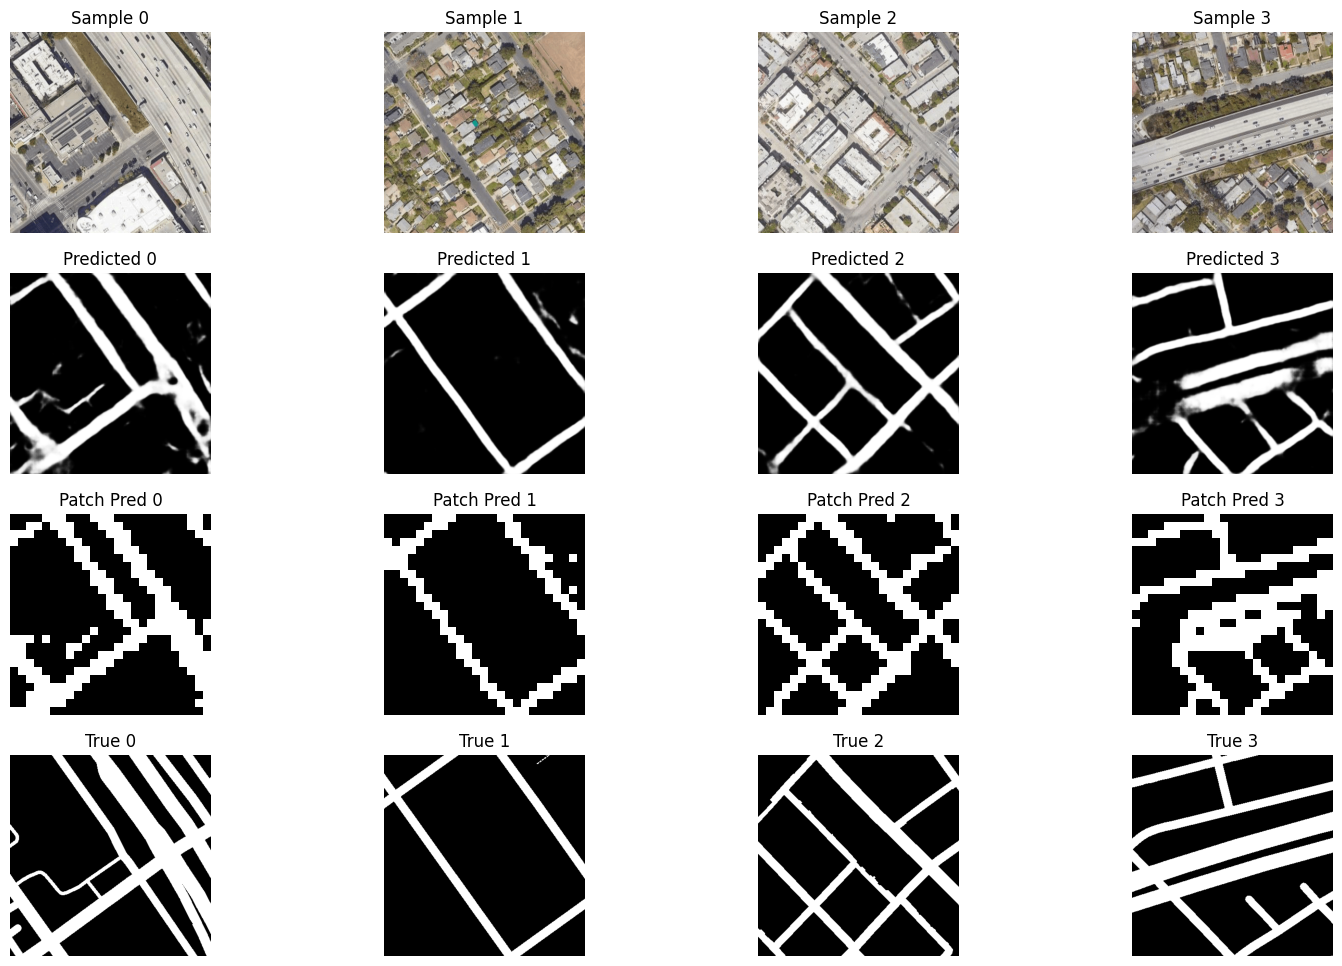

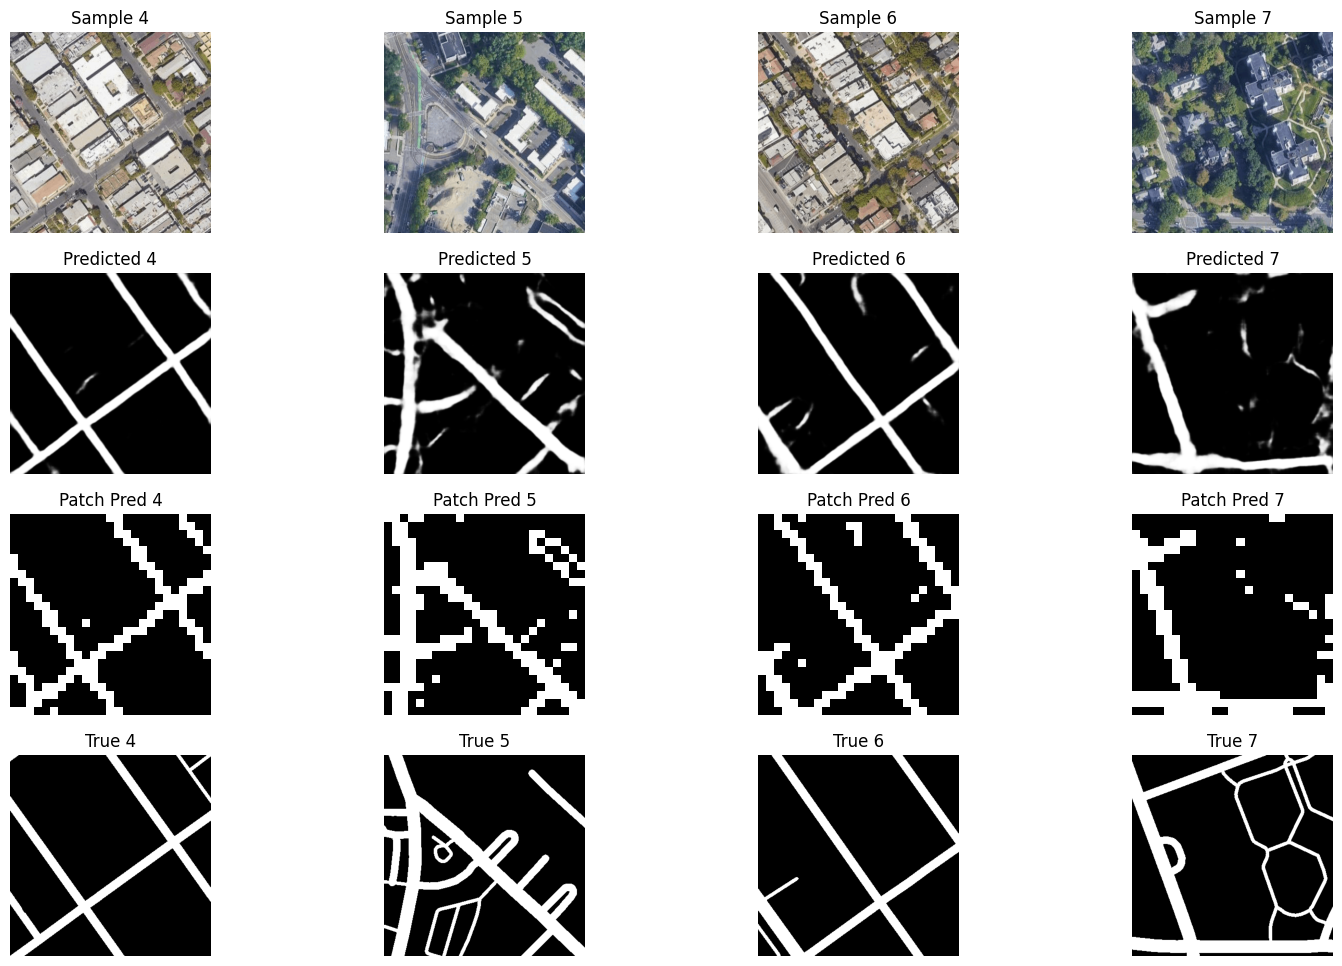

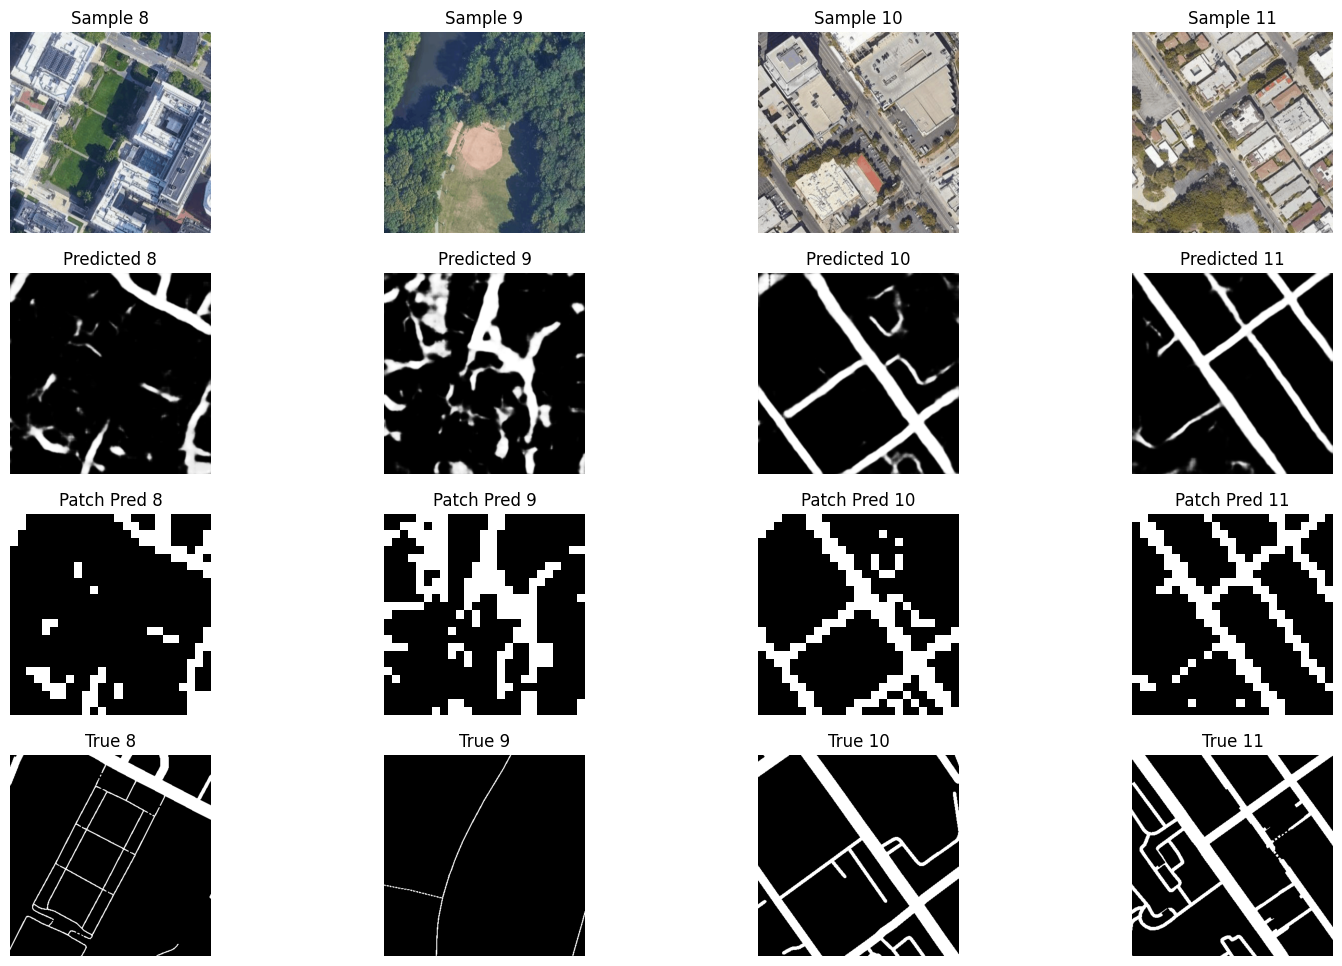

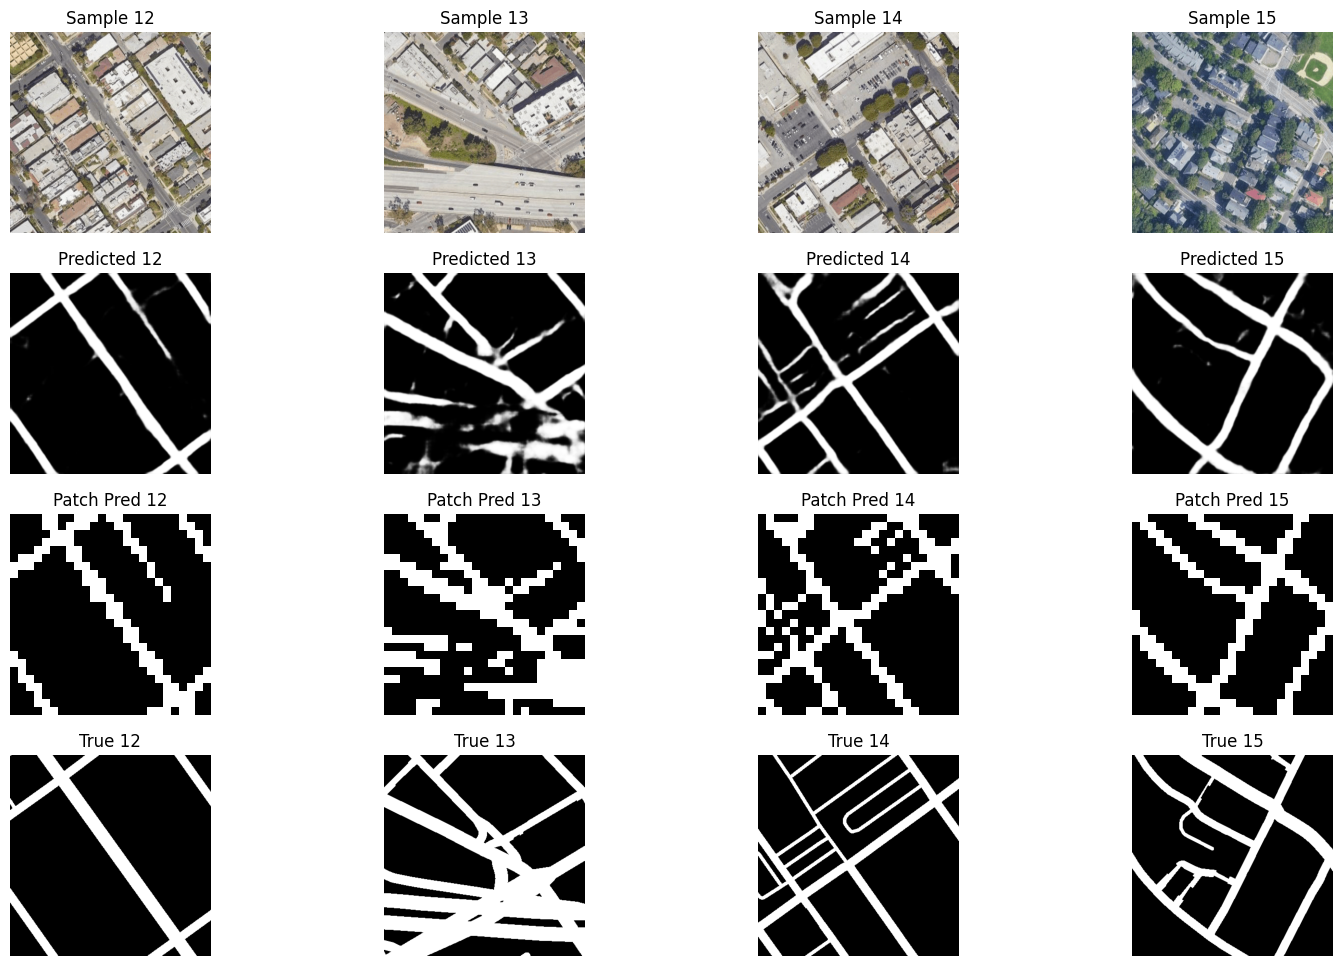

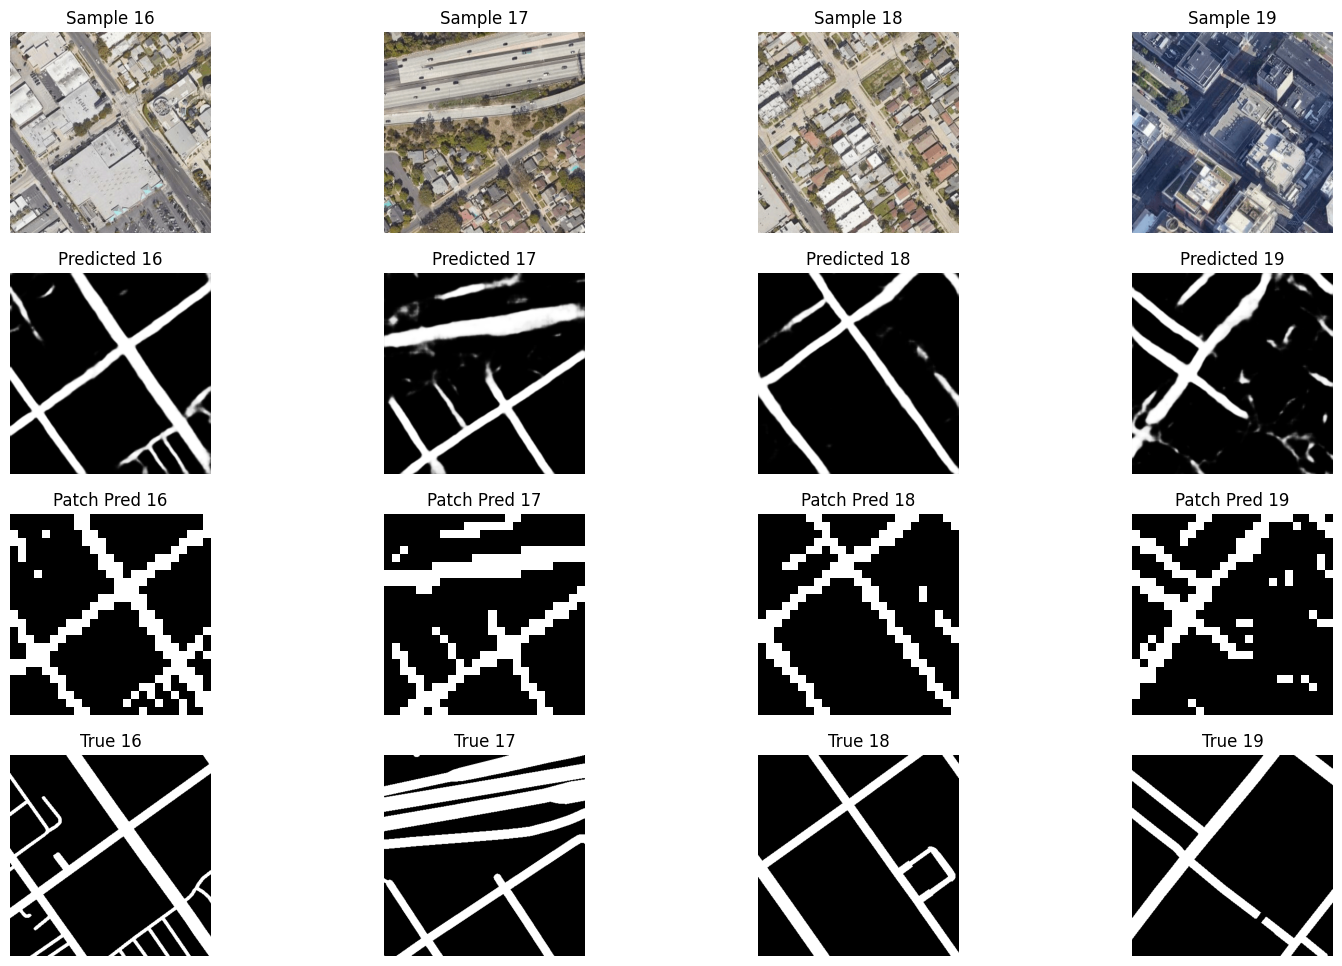

In [111]:
plot_samples(img, mask, pred, patch_pred)